In [1]:
import datetime
import warnings

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import skorch

from dataset import StockDataset
from denoising.autoencoder import *
from metrics import get_metrics

from yahoo_fin_api import load_df

%matplotlib inline
warnings.filterwarnings(action='ignore')

## Purpose

The distribution of gold, bond data would be very different with stock data. Factors that influence the price of stocks, gold, and bond are very different. For example, difference of basemoney rate influences the prices very differently. So by putting the gold and bond data, we can check whether the autoencoder trained for stock data also can work for other types of financial data.

In [2]:
DATE_STR = '28022023-024108'
CONV1_KERNEL = 51
CONV2_KERNEL = 51
CONV3_KERNEL = 51

cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)

cnn_encoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-encoder.pt')), 
cnn_decoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-decoder.pt'))

<All keys matched successfully>

In [3]:
DATE_STR = '28022023-151344'
CONV1_KERNEL = 51
CONV2_KERNEL = 51
CONV3_KERNEL = 51

cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)

cnn_encoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-encoder.pt')), 
cnn_decoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-decoder.pt'))

<All keys matched successfully>

In [4]:
DATE_STR = '01032023-142823'
CONV1_KERNEL = 31
CONV2_KERNEL = 31
CONV3_KERNEL = 31

cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)

cnn_encoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-encoder.pt')), 
cnn_decoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-decoder.pt'))

<All keys matched successfully>

In [5]:
cnn_encoder.eval(), cnn_decoder.eval()

(CnnEncoder(
   (encoder_cnn): Sequential(
     (0): Conv1d(1, 8, kernel_size=(31,), stride=(1,), padding=(31,))
     (1): ReLU(inplace=True)
     (2): Conv1d(8, 16, kernel_size=(31,), stride=(1,), padding=(31,))
     (3): ReLU(inplace=True)
     (4): Conv1d(16, 32, kernel_size=(31,), stride=(1,), padding=(31,))
     (5): ReLU(inplace=True)
     (6): Conv1d(32, 64, kernel_size=(31,), stride=(1,), padding=(31,))
     (7): ReLU(inplace=True)
   )
 ),
 CnnDecoder(
   (decoder_cnn): Sequential(
     (0): ConvTranspose1d(64, 32, kernel_size=(31,), stride=(1,), padding=(31,))
     (1): ReLU(inplace=True)
     (2): ConvTranspose1d(32, 16, kernel_size=(31,), stride=(1,), padding=(31,))
     (3): ReLU(inplace=True)
     (4): ConvTranspose1d(16, 8, kernel_size=(31,), stride=(1,), padding=(31,))
     (5): ReLU(inplace=True)
     (6): ConvTranspose1d(8, 1, kernel_size=(31,), stride=(1,), padding=(31,))
   )
 ))

In [6]:
def get_data(data_name, minmax_scaling=True):
    df = load_df(f'data/{data_name}.csv')
    if minmax_scaling:
        df[df.columns] = MinMaxScaler().fit_transform(df.values)
    data = df['Mean']
    df = df.rename(columns={'Mean': 'True'})
    data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

    return df, data

In [7]:
snp_df, snp_data = get_data('snp', False)
gold_df, gold_data = get_data('gold', False)
bond_df, bond_data = get_data('treasury-yield-10y', False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
snp_data = snp_data.to(device)
gold_data = gold_data.to(device)
bond_data = bond_data.to(device)

cnn_encoder = cnn_encoder.to(device)
cnn_decoder = cnn_decoder.to(device)

In [9]:
def predict(df, data):
    output = cnn_decoder(cnn_encoder(data)).detach().cpu().numpy().squeeze()
    df['CNNPred'] = output

    return df

In [10]:
snp_df = predict(snp_df, snp_data)
gold_df = predict(gold_df, gold_data)
bond_df = predict(bond_df, bond_data)

In [11]:
df_dict = {
    'S&P 500': snp_df[['True', 'CNNPred']],
    'Gold': gold_df[['True', 'CNNPred']],
    'Treaury Yield 10 Years': bond_df[['True', 'CNNPred']],
}

result_df = get_metrics(df_dict, 'Data')
result_df

,mean_squared_error,R-squared,snr,psnr
Data,,,,
S&P 500,3107.397411,0.996942,30.290311,38.696757
Gold,1102.799160,0.995824,31.105776,35.810113
Treaury Yield 10 Years,0.194077,0.951691,20.518916,26.642752


In [12]:
result_df.to_csv('results/autoencoder-kernel31-results.csv')

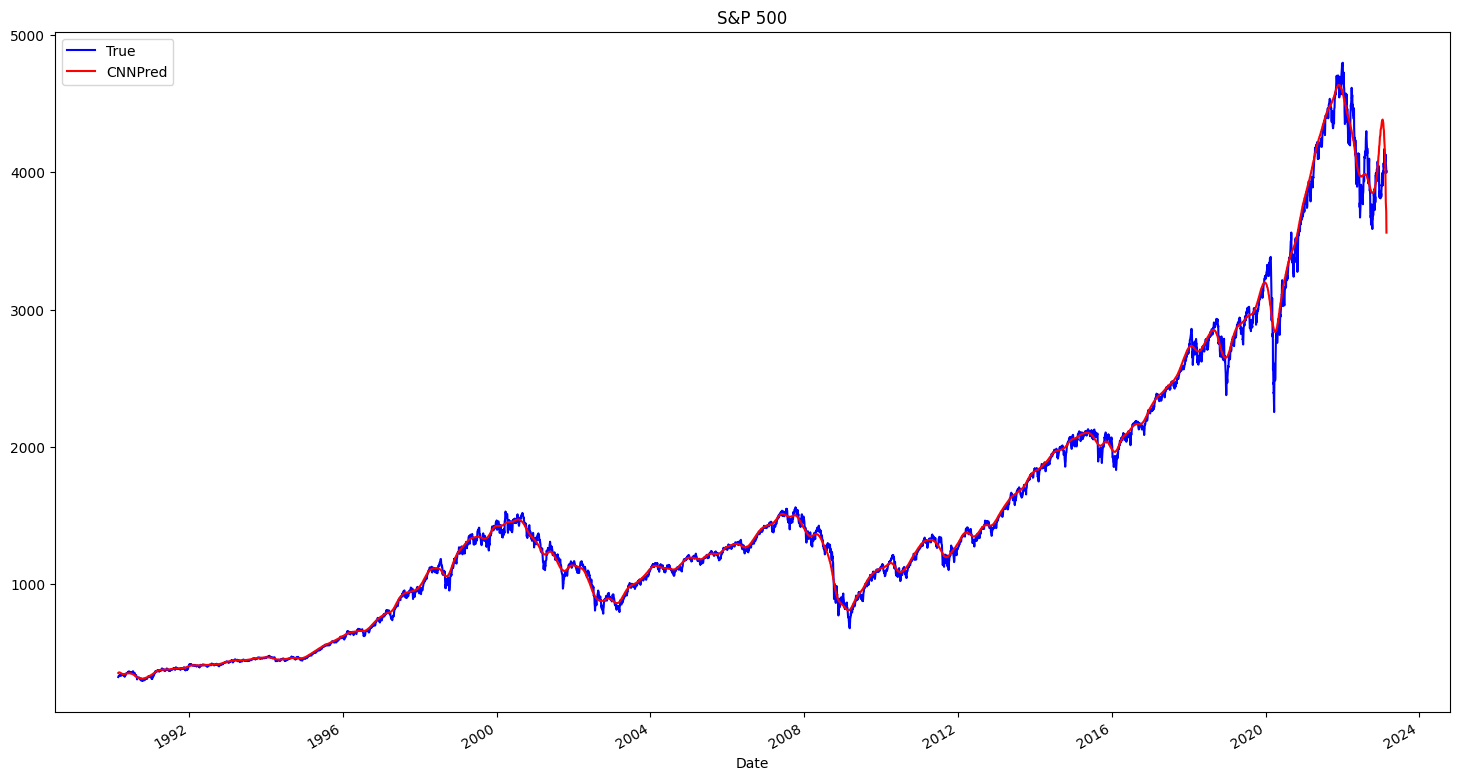

In [13]:
_ = snp_df[['True', 'CNNPred']].plot(color=['b', 'r'], title='S&P 500', figsize=(18, 10))

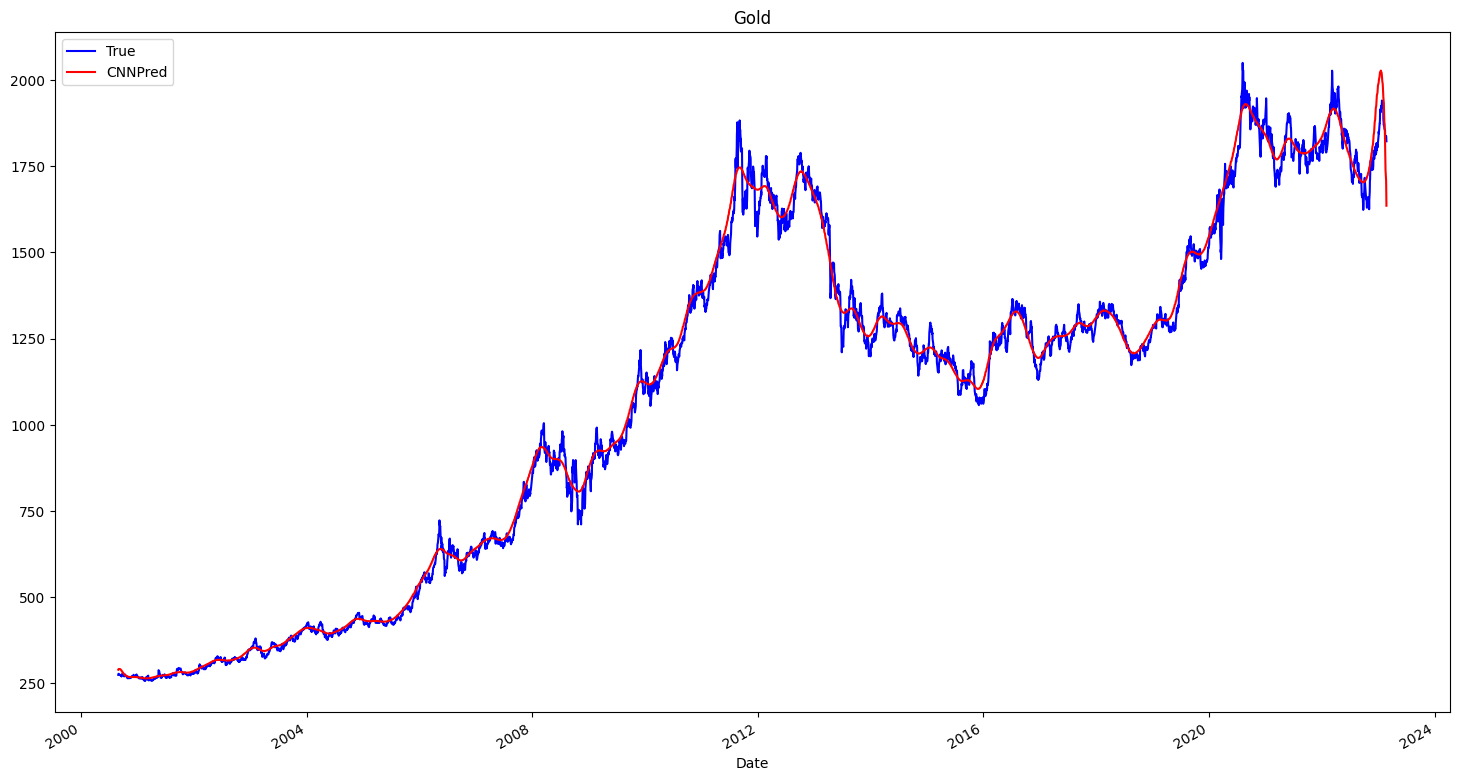

In [14]:
_ = gold_df[['True', 'CNNPred']].plot(color=['b', 'r'], title='Gold', figsize=(18, 10))

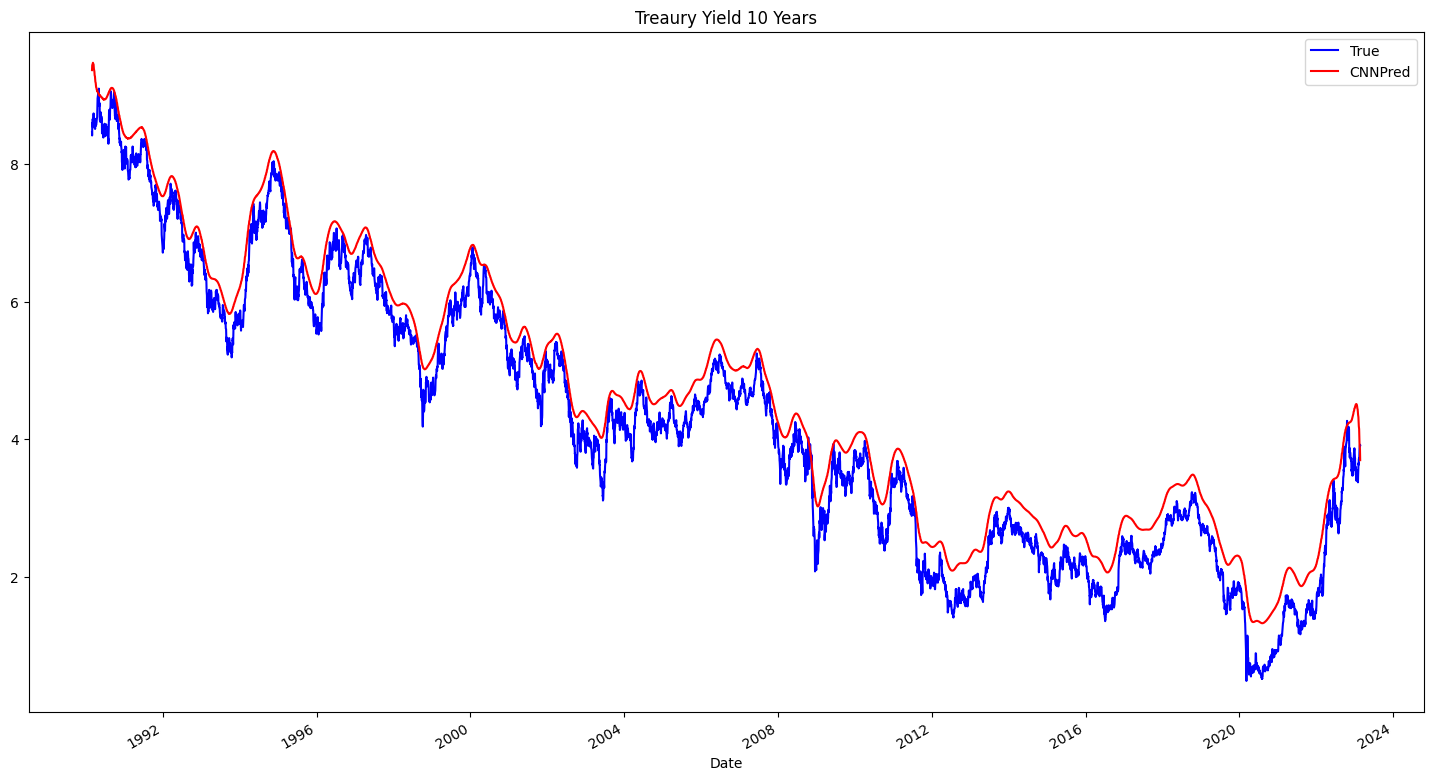

In [15]:
_ = bond_df[['True', 'CNNPred']].plot(color=['b', 'r'], title='Treaury Yield 10 Years', figsize=(18, 10))

AutoEncoder seems working for other types of financial data.